## Sentiment Prediction using Random Forest Classifier & SVM

In [3]:
import spacy
import sklearn
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load pre-processed data
df = pd.read_csv("data/all_cleaned")
df.sample(3)

,stars,title,text,text_clean,sentiment,text_sid_vader_neg,text_sid_vader_neu,text_sid_vader_pos,text_sid_vader_compound,text_sid_textblob_polarity
8553,1,Trade in is a Con,Purchased 2 iPhone 13 minis. I chose Apple as ...,purchas 2 iphon 13 mini i chose appl as they h...,negative,0.035,0.965,0.000,-0.2960,0.078125
12766,2,Google is bombarding me with unwanted…,Google is bombarding me with unwanted material...,googl is bombard me with unwant materi and is ...,neutral,0.092,0.908,0.000,-0.5221,-0.056667
4082,5,Very good service,"Very good service, never had a problem with th...",veri good servic never had a problem with the ...,positive,0.000,0.576,0.424,0.6319,0.700000


#### Quick bucket size check

In [9]:
df["sentiment"].value_counts(normalize=True)

negative    0.333333
neutral     0.333333
positive    0.333333
Name: sentiment, dtype: float64

#### Downloading large spacy model (~700 MB)

In [4]:
%%capture
!python -m spacy download en_core_web_lg

#### Tokenizing and vectorizing data with spaCy (3-5 mins)

In [5]:
nlp = spacy.load('en_core_web_lg')

def vectorize_text(text):
    doc = nlp(text)
    return doc.vector

df['text_vector'] = df['text_clean'].apply(vectorize_text)
df.head()

,stars,title,text,text_clean,sentiment,text_sid_vader_neg,text_sid_vader_neu,text_sid_vader_pos,text_sid_vader_compound,text_sid_textblob_polarity,text_vector
0,1,Had 5G speed plummet from 400mbps down…,With just one device connected 4G+ speed 90mbp...,with just one devic connect 4g speed 90mbps do...,negative,0.050,0.934,0.016,-0.4497,-0.075556,"[0.047985982, 0.18046616, -0.12221394, -0.0184..."
1,1,Very Slow,Very Slow - avoid this company Recently signed...,veri slow avoid this compani recent sign up af...,negative,0.017,0.828,0.154,0.9294,0.089815,"[-0.043955635, 0.159388, -0.21402094, -0.04922..."
2,2,Underwhelming service and functionality,I have been using the service for about 3 mont...,i have been use the servic for about 3 month g...,neutral,0.127,0.804,0.069,-0.6496,0.080000,"[0.0295655, 0.13602999, -0.17271744, -0.102811..."
3,1,I can't wait to switch VPNs,I can't wait to switch VPNs. Every time my PC ...,i can't wait to switch vpns everi time my pc a...,negative,0.105,0.870,0.025,-0.8126,-0.012500,"[0.09425794, 0.10422098, -0.14998992, -0.05015..."
4,1,Horrible,Horrible. Beware!! I signed up and after m...,horribl bewar i sign up and after multipl atte...,negative,0.048,0.884,0.068,0.5267,-0.145833,"[0.029379677, 0.12570287, -0.22697774, 0.02288..."


#### Training models and evaluating them (Random Forest Classifier & Support Vector Machine)

In [10]:
# Features & Target
X = df['text_vector'].tolist()
Y = df['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [28]:
# Fit & predict 
rf_clf = RandomForestClassifier(n_estimators=121, max_depth=7, min_samples_split=5, min_samples_leaf=3)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.75      0.81      0.78       915
     neutral       0.67      0.59      0.63       882
    positive       0.80      0.82      0.81       914

    accuracy                           0.75      2711
   macro avg       0.74      0.74      0.74      2711
weighted avg       0.74      0.75      0.74      2711



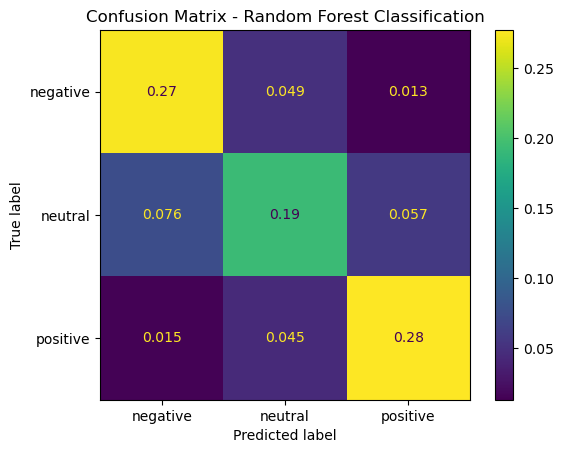

In [29]:
# Confusion matrix of the first model
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix - Random Forest Classification")
plt.show()

In [30]:
# Fit & predict
svm_clf = SVC(C=10, degree=2, gamma='scale', kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84       915
     neutral       0.76      0.71      0.73       882
    positive       0.88      0.88      0.88       914

    accuracy                           0.82      2711
   macro avg       0.82      0.82      0.82      2711
weighted avg       0.82      0.82      0.82      2711



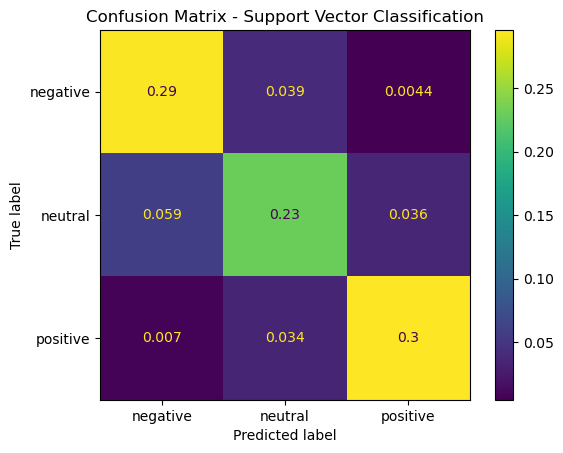

In [31]:
# Confusion matrix of the second model
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix - Support Vector Classification")
plt.show()

#### Hyperparameter tuning (Random Forest Classifier)

In [23]:
# Tuning model using RandomizedSearchCV
param_dist = {
            'n_estimators': randint(50, 200),
            'max_depth': randint(2, 8),
            'min_samples_split': randint(2, 6),
            'min_samples_leaf': randint(1, 4)
             }

random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=50, cv=5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)


Best hyperparameters:  {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 121}


In [ ]:
# Tuning model using GridSearchCV
param_grid = {
            'n_estimators': [120, 121, 122],
            'max_depth': [6, 7, 8],
            'min_samples_split': [4, 5, 6],
            'min_samples_leaf': [2, 3, 4]
             }

# Could additionaly try these parameters
# "max_features": ['auto', 'sqrt', 'log2']
# "bootstrap": [True, False]
              
grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

#### Hyperparameter tuning (Support Vector Machine)

In [24]:
# Tuning model using RandomizedSearchCV
param_dist = {
            'C': uniform(0, 10), 
            'kernel': ['linear', 'rbf', 'poly'], 
            'degree': range(2, 6), 
            'gamma': ['scale', 'auto']
             }

random_search = RandomizedSearchCV(svm_clf, param_distributions=param_dist, n_iter=50, cv=5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'C': 9.985439082465788, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Tuning model using GridSearchCV
param_grid = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto']
             }
              
# Could additionaly try these parameters
# "class_weight": ['balanced', None]
# "random_state": [1, 42, 100, None]

grid_search = GridSearchCV(svm_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

#### Export the trained models

In [32]:
joblib.dump(rf_clf, 'trained_models/rf_trained.pkl')
joblib.dump(svm_clf, 'trained_models/svm_trained.pkl')

['trained_models/svm_trained.pkl']

#### Load the trained models and test them

In [40]:
rf_trained = joblib.load("trained_models/rf_trained.pkl")
svm_trained = joblib.load("trained_models/svm_trained.pkl")

test_review = input("Enter your review: ")
test_review_vector = vectorize_text(test_review).reshape(1, -1)

prediction_rf = rf_trained.predict(test_review_vector)
prediction_svm = svm_trained.predict(test_review_vector)

print("RF model sentiment prediction: ", prediction_rf)
print("SVM model sentiment prediction: ", prediction_svm)

RF model sentiment prediction:  ['neutral']
SVM model sentiment prediction:  ['neutral']
